In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
import os

!apt-get install unrar-free -y

!unrar x /content/ampuls.rar

train_ds = tf.keras.utils.image_dataset_from_directory("/content/ampuls", image_size=(180, 180), batch_size=32)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  pike8.0
The following NEW packages will be installed:
  unrar-free
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 23.6 kB of archives.
After this operation, 72.7 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 unrar-free amd64 1:0.0.2-0.1 [23.6 kB]
Fetched 23.6 kB in 1s (44.5 kB/s)
Selecting previously unselected package unrar-free.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../unrar-free_1%3a0.0.2-0.1_amd64.deb ...
Unpacking unrar-free (1:0.0.2-0.1) ...
Setting up unrar-free (1:0.0.2-0.1) ...
Processing triggers for man-db (2.10.2-1) ...

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/ampuls.rar

Creating    ampuls                                                    OK
Creating    ampu

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [4]:
transformasyonlar = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

])

veri_seti = datasets.ImageFolder(root='ampuls', transform=transformasyonlar)

hazir_veriler = DataLoader(veri_seti, batch_size=4, shuffle=True)

print(f"Toplam Resim Sayısı: {len(veri_seti)}")
print(f"Sınıf İsimleri: {veri_seti.classes}")

Toplam Resim Sayısı: 72
Sınıf İsimleri: ['error', 'lambs']


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class AmpulAI(nn.Module):
  def __init__(self):
    super(AmpulAI, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)

    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(32 * 56 * 56, 128)
    self.fc2 = nn.Linear(128, 2)

  def forward(self, x):
    # işlem sırası
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))

    # veriyi düzleştir
    x = x.view(-1, 32 * 56 * 56)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AmpulAI().to(device)

print(model)

AmpulAI(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10

print("Eğitim Başlıyor... ")

for epoch in range(epochs):
  running_loss = 0.0
  for i, data in enumerate(hazir_veriler, 0):
      inputs, labels = data[0].to(device), data[1].to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      running_loss += loss.item()

  print(f"Epoch {epoch + 1} bitti. Ortalama Hata: {running_loss / len(hazir_veriler):.4f}")

print("Eğitim tamam")

Eğitim Başlıyor... 
Epoch 1 bitti. Ortalama Hata: 3.8479
Epoch 2 bitti. Ortalama Hata: 0.7853
Epoch 3 bitti. Ortalama Hata: 0.5818
Epoch 4 bitti. Ortalama Hata: 0.6616
Epoch 5 bitti. Ortalama Hata: 0.5871
Epoch 6 bitti. Ortalama Hata: 0.4861
Epoch 7 bitti. Ortalama Hata: 0.3695
Epoch 8 bitti. Ortalama Hata: 0.4856
Epoch 9 bitti. Ortalama Hata: 0.3500
Epoch 10 bitti. Ortalama Hata: 0.2780
Eğitim tamam


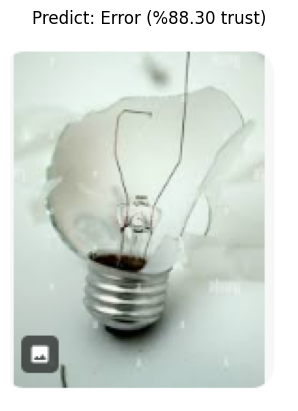

In [10]:
from PIL import Image
import matplotlib.pyplot as plt

def guess(image_path):
    # load picture and ready model
    img = Image.open(image_path).convert('RGB')
    input_img = transformasyonlar(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
      output = model(input_img)
      _, predict = torch.max(output, 1)
      possibility = torch.nn.functional.softmax(output, dim=1)

    class_names = ['Error', 'Lambs']
    conclusion = class_names[predict.item()]
    percentage = possibility[0, predict.item()].item() * 100

    plt.imshow(img)
    plt.title(f"Predict: {conclusion} (%{percentage:.2f} trust)")
    plt.axis('off')
    plt.show()

guess('/content/ampuls/error/ampul2.png')

In [12]:
torch.save(model.state_dict(), 'signify_ampul_modeli.pth')

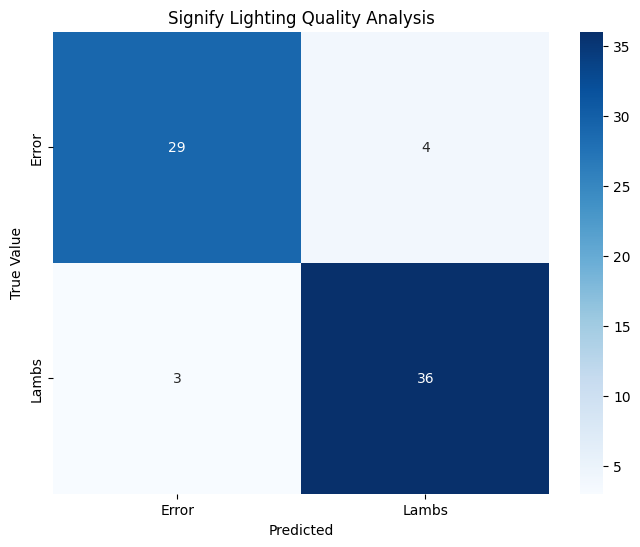

              precision    recall  f1-score   support

       Error       0.91      0.88      0.89        33
       Lambs       0.90      0.92      0.91        39

    accuracy                           0.90        72
   macro avg       0.90      0.90      0.90        72
weighted avg       0.90      0.90      0.90        72



In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = []
y_true = []

model.eval()
with torch.no_grad():
  for inputs, labels in hazir_veriler:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      y_pred.extend(preds.cpu().numpy())
      y_true.extend(labels.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Error', 'Lambs'], yticklabels=['Error', 'Lambs'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True Value')
plt.title('Signify Lighting Quality Analysis')
plt.show()

print(classification_report(y_true, y_pred, target_names=['Error', 'Lambs']))